# Analiza podatkov iz Phyphox-a

## Potrebne knjižnice in funkcije
Potrebno izvesti le enkrat (ker ves proces poteka v spletnem brskalniku vaše naprave, lahko tak korak traja nekaj časa).

In [5]:
import numpy as np
import pandas as pd
from scipy import signal
import sys,os
import matplotlib.pyplot as plt
%pip install -q ipympl
%matplotlib widget

In [6]:
def Raw_Filtered_Plot(t,y,fy,measurement='Measurement',xlabel='x',ylabel='y',legend='True'):
    '''Plot Raw and Filtered data over time'''
    fig = plt.figure()
    plt.plot(t,y,label=f'Neobdelani podatki')# LDJ = {ldj:.0f}')
    plt.plot(t,fy,label=f'Filtirani podatki')# LDJ = {ldjf:.0f}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(measurement)
    if legend: plt.legend(loc='upper right')
    plt.show()

In [7]:
def AnalyzeSignal(d,ydataNo,order=8,CNr=0.1,Start=0,Interval=0,plot=True,legend='True'):
    '''Get Raw and Filtered data. Using Lowpass Butterforth filter with order=order and Cnr=f_crit/f_Nyquist'''
    
    # Get sampling frequency over the whole interval (cutting off cut first and last points)
    cut = 0
    t, y = [d.iloc[:,col][cut:-(cut+1)] for col in (0,ydataNo)]
    dtlist = t.diff()[1:]
    fslist = 1/dtlist # Sampling frequency
    fs, sfs = np.average(fslist),np.std(fslist)
    sampling = f', Vzorčenje: $\\nu$ = {fs:.0f} Hz, $\sigma_\\nu =$ {sfs:.0f} Hz'
    
    # Filter and plot interval given in seconds
    if Interval == 0:
        Intervals = len(d)-int(Start*fs)
    else:
        Intervals = int(Interval*fs)
    Starts = int(Start*fs)
    t, y = [d.iloc[:,col][Starts:Starts+Intervals] for col in (0,ydataNo)]
    b, a = signal.butter(order, CNr * (0.5*fs), fs = fs) # Lowpass Butterforth filter with order=order and Cnr=f_crit/f_Nyquist
    fy = signal.filtfilt(b, a, y) # Apply filter forward and backward to a signal
    Raw_Filtered_Plot(t,y,fy,
                      measurement,
                      xlabel=d.columns[0]+sampling,
                      ylabel=d.columns[ydataNo],
                      legend=legend)
    return #t, y, fy

## Meritve

### PhyPhox
[PhyPhox](https://phyphox.org/) je odprtokodna aplikacija za mobilne naprave. Z njo lahko zajemamo podatke senzorjev, npr. vztrajnostnih merilnih enot ([IMU - iz angl. Inertial Measurement Unit](https://en.wikipedia.org/wiki/Inertial_measurement_unit)). IMU v naših pametnih telefonih ali tablicah bomo uporabili za zajem pospeškov (s pospeškometri) in kotnih hitrosti (z giroskopi) v biomehanskih meritvah.

**Primer protokola meritve** z aplikacijo [PhyPhox](https://phyphox.org/) z mobitelom in prenosnikom, na katerem nadziramo meritev (dve napravi nista pogoj, je pa izvajanje bolj kontrolirano. Napravi morata biti v istem omrežju - uredite si npr. Mobile hotspot ali uporabite Eduroam, ki je v laboraotriju):
>#### Pred meritvijo (v Phyphox aplikaciji na telefonu)
>1. Izberi način zajema, npr. *Gyroscope (rotation rate)* ali *Acceleration* (z ali brez težnega pospeška).
>2. Izberi *Allow remote access* in Phybox ti ponudi http naslov
>3. Izberi *Timed run* z *Countdown sound*, *Start sound*, *Stop sound*
>4. Prenosnik namesti za meritev (položaj, orientacija!)

>#### Meritev (v spletnem brskalniku prenosnika odpri ponujeni http naslov)
>1. Zaženi in **izvedi meritev**
>2. Izberi *Export data* in shrani podatke
>3. Pred ponovno meritvijo izberi *Clear recorded data*

>#### Obdelava podatkov
Shranjen podatke uvozi, preglej in obdelaj v JupyterLite v tej interaktivni beležnici (glej nižje).

### Filtriranje signala

Včasih je koristno merske podatke filtrirati. V biomehaniki to pogosto storimo tako, da zgladimo vse na časovni skali manjši od najhitrejšega pričakovanega odziva telesa (odziv mišično-skeletnega sistema na zunanje dražljaje je približno 0,2 s). Na izmerjenih podatkih bomo preiskusili nizkopasovni [Butterworthov filter](https://en.wikipedia.org/wiki/Butterworth_filter), ki prepusti nizke frekvence frekvence signala, višje pa oslabi. Parametra filtra v spodnji kodi sta:
- "order", ki predstavlja red filtra. Višji, ko je red, bolj "ostro" odreže visoke frekvence. Vrednost parametra lahko pustite kar na 5,
- "CNr", ki je razmerje med kritično frekvenco in polovično frekvenco vzorčenja (Nykvistova frekvenca). Pri kritični frekvenci jakost filtriranega signala pade na $1/\sqrt{2}$ nefiltrirane vrednosti. Vrednost parametra je lahko v intervalu (0,1). Poskusite npr. vrednosti CNr = 0.01 in CNr = 0.1.

## Analiza merski podatkov

In [8]:
measurement = 'data/Raw Data.csv'
print(f'Berem datoteko: \"{measurement}\"')
pd.read_csv(measurement)

Berem datoteko: "data/Raw Data.csv"


,Time (s),Acceleration x (m/s^2),Acceleration y (m/s^2),Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.019078,0.478565,9.635897,-1.071985,9.707146
1,0.021623,0.449851,9.643075,-1.093520,9.715300
2,0.024156,0.404387,9.645468,-1.119841,9.718674
3,0.026688,0.356531,9.655040,-1.136591,9.728245
4,0.029221,0.315853,9.669396,-1.160519,9.743911
...,...,...,...,...,...
17131,43.410774,2.658426,1.507478,9.466006,9.947110
17132,43.413307,2.651248,1.509871,9.449257,9.929616
17133,43.415840,2.658426,1.505085,9.444471,9.926256
17134,43.418373,2.677568,1.509871,9.451650,9.938952


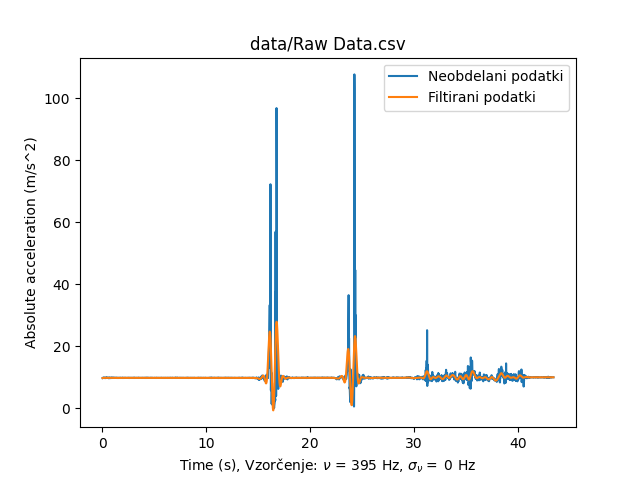

In [14]:
# Izberi podatke za prikaz:
ydataNo = 4 # Zaporedna številka stolpca za analizo
Start = 0 # Začetek intervala [s]
Interval = 0  # Dolžina intervala [s]. Izberi 0 za celoten interval.

# Filtriranje signala z Butherworthovim filtrom (odreže visoke frekvence):
order = 5 # Red filtra. Lahko pustite kar 5.
CNr = 0.01 #  Poskusite 0.01 and 0.1. Izbira je možna v intervalu (0,1). CNr predstavlja f_crit/f_Nyquist filtra. 
AnalyzeSignal(pd.read_csv(measurement),ydataNo,order,CNr, Start,Interval)

## 1. naloga: Višina skoka
Višino skoka ($h$) lahko izračunamo iz časa skoka ($t$). Iz enačbe za prosti pad namreč lahko zapišemo
$$h = \frac{g \left(\frac{t}{2}\right)^2}{2} = \frac{g t^2}{8} \: ,$$
kjer je $g$ težni pospešek.

Z mobilnim telefonom in aplikacijo Phyphox izmerite pospeške med skokom. Iz analize pospeškov izmerite čas skoka ($t$) in iz tega višino skoka ($h$). Primerjajte rezultat s preprosto meritvijo oziroma oceno višine skoka, ki si jo zamislite sami.

## 2. naloga: Časovno merjeni test vstani in pojdi
Časovno merjeni test vstani in pojdi (angl.: Timed Up and Go Test – TUG) je poceni, preprosta, lahko in hitro izvedljiva široko uporabna klinična izvedbena mera funkcije spodnjih udov, premičnosti in ocene tveganja za pojavnost padcev (glejte npr. [Jakovljević, 2013](https://physio.si/wp-content/uploads/2021/07/6.-Casovno-merjeni-test_2013_No1_p38-47.pdf)). S senzorji pametnega telefona lahko izvedemo t.i. instrumentalizirani TUG (glejte npr. [Mellone et al., 2012](https://doi.org/10.1016/j.gaitpost.2012.02.006)).

Z mobilnim telefonom in aplikacijo Phyphox izmerite kotne hitrosti in/ali pospeške med Časovno merjenim testom vstani in pojdi (za protokol izvedbe testa glejte npr. [ocenjevalni list CDC](https://www.cdc.gov/steadi/pdf/TUG_test-print.pdf)). Iz analize podatkov izmerite čas testa in ga primerjajte z rezultatom izmerjenim z uro. Nato poskusite oceniti različne faze testa, npr.:
[1) vstajanje
2) 3 m hoje (prvi del)
3) obrat
4) 3 m hoje (drugi del)
5) obrat
6) sedanje.](fig/TUG_faze.png)

Ali lahko zaznate tudi obrat med hojo in posamezne korake? Kaj bi še lahko ocenili iz vaših podatkov? Glej npr. [meritve anteriorno-posteriornega pospeška iz Mellone et al., 2012](fig/TUG_APacc.png)

![alt text for screen readers](fig/TUG_faze.png "Text to show on mouseover")
<img src="fig/TUG_faze.png" alt="MarineGEO circle logo" style="height: 100px; width:100px;"/>